# Unsupervised Learning

In unsupervised learning, the task is to infer hidden structure from
unlabeled data, comprised of training examples $\{x_n\}$.

We demonstrate with an example in Edward. A webpage version is available at
http://edwardlib.org/tutorials/unsupervised.

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import six
import tensorflow as tf

from edward.models import Categorical, InverseGamma, Mixture, \
    MultivariateNormalDiag, Normal

plt.style.use('ggplot')

## Data

Use a simulated data set of 2-dimensional data points
$\mathbf{x}_n\in\mathbb{R}^2$.

In [2]:
def build_toy_dataset(N):
  pi = np.array([0.4, 0.6])
  mus = [[1, 1], [-1, -1]]
  stds = [[0.1, 0.1], [0.1, 0.1]]
  x = np.zeros((N, 2), dtype=np.float32)
  for n in range(N):
    k = np.argmax(np.random.multinomial(1, pi))
    x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))

  return x


N = 500  # number of data points
K = 2  # number of components
D = 2  # dimensionality of data
ed.set_seed(42)

x_train = build_toy_dataset(N)

We visualize the generated data points.

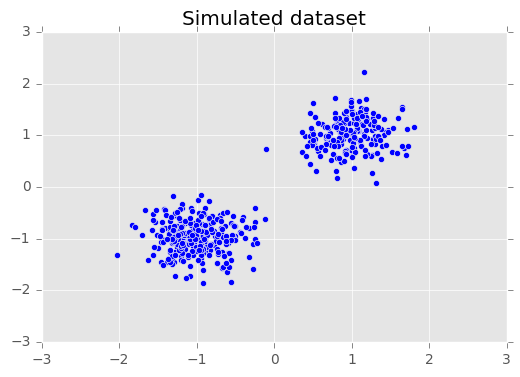

In [3]:
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.axis([-3, 3, -3, 3])
plt.title("Simulated dataset")
plt.show()

## Model

A mixture model is a model typically used for clustering.
It assigns a mixture component to each data point, and this mixture component
determines the distribution that the data point is generated from. A
mixture of Gaussians uses Gaussian distributions to generate this data
(Bishop, 2006).

For a set of $N$ data points,
the likelihood of each observation $\mathbf{x}_n$ is

\begin{align*}
  p(\mathbf{x}_n \mid \pi, \mu, \sigma)
  &=
  \sum_{k=1}^K \pi_k \, \text{Normal}(\mathbf{x}_n \mid \mu_k, \sigma_k).
\end{align*}

The latent variable $\pi$ is a $K$-dimensional probability vector
which mixes individual Gaussian distributions, each
characterized by a mean $\mu_k$ and standard deviation $\sigma_k$.

Define the prior on $\pi\in[0,1]$ such that $\sum_{k=1}^K\pi_k=1$ to be

\begin{align*}
  p(\pi)
  &=
  \text{Dirichlet}(\pi \mid \alpha \mathbf{1}_{K}).
\end{align*}

Define the prior on each component $\mathbf{\mu}_k\in\mathbb{R}^D$ to be

\begin{align*}
  p(\mathbf{\mu}_k)
  &=
  \text{Normal}(\mathbf{\mu}_k \mid \mathbf{0}, \sigma^2\mathbf{I}).
\end{align*}

Define the prior on each component $\mathbf{\sigma}_k\in\mathbb{R}^D$ to be

\begin{align*}
  p(\mathbf{\sigma}_k)
  &=
  \text{InverseGamma}(\mathbf{\sigma}_k \mid a, b).
\end{align*}

We build two versions of the model in Edward: one jointly with the
mixture assignments $c_n\in\{0,\ldots,K-1\}$ as latent variables,
and another with them summed out.

The joint version is written as follows.

In [4]:
mu = Normal(mu=tf.zeros([K, D]), sigma=tf.ones([K, D]))
sigma = InverseGamma(alpha=tf.ones([K, D]), beta=tf.ones([K, D]))
c = Categorical(logits=tf.zeros([N, K]))
x = Normal(mu=tf.gather(mu, c), sigma=tf.gather(sigma, c))

The collapsed version marginalizes out the mixture assignments. We
implement this with the `Mixture` random variable.

In [5]:
mu = Normal(mu=tf.zeros([K, D]), sigma=tf.ones([K, D]))
sigma = InverseGamma(alpha=tf.ones([K, D]), beta=tf.ones([K, D]))
cat = Categorical(logits=tf.zeros([N, K]))
components = [
    MultivariateNormalDiag(mu=tf.ones([N, 1]) * mu[k],
                           diag_stdev=tf.ones([N, 1]) * sigma[k])
    for k in range(K)]
x = Mixture(cat=cat, components=components)

We will use the collapsed version in this analysis.

## Inference

Perform variational inference.
The latent variables are the
component means and component variances.
Define the variational model to be

\begin{align*}
 q(\mu, \sigma \;;\; \lambda)
 &=
 \prod_{k=1}^K
 \text{Normal}(\mu_k; \lambda_{\mu_k})
 ~
 \text{InverseGamma}(\sigma_k; \lambda_{\sigma_k}).
\end{align*}

The model in Edward is

In [6]:
qmu = Normal(
    mu=tf.Variable(tf.random_normal([K, D])),
    sigma=tf.nn.softplus(tf.Variable(tf.zeros([K, D]))))
qsigma = InverseGamma(
    alpha=tf.nn.softplus(tf.Variable(tf.random_normal([K, D]))),
    beta=tf.nn.softplus(tf.Variable(tf.random_normal([K, D]))))

Run variational inference for 4000 iterations and 20 latent variable
samples per iteration.

In [7]:
inference = ed.KLqp({mu: qmu, sigma: qsigma}, data={x: x_train})
inference.initialize(n_samples=20, n_iter=4000)

sess = ed.get_session()
tf.global_variables_initializer().run()

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  t = info_dict['t']
  if t % inference.n_print == 0:
    print("\nInferred cluster means:")
    print(sess.run(qmu.mean()))

 400/4000 [ 10%] ███                            ETA: 330s | Loss: 1479.463
Inferred cluster means:
[[-0.74353886 -1.58002555]
 [ 0.89042461  1.48513532]]
 800/4000 [ 20%] ██████                         ETA: 176s | Loss: 1060.820
Inferred cluster means:
[[-0.59472769 -0.91557807]
 [ 1.16395271  0.91445965]]
1200/4000 [ 30%] █████████                      ETA: 124s | Loss: 1125.076
Inferred cluster means:
[[-1.19923842 -1.11298919]
 [ 1.28302431  1.25858235]]
1600/4000 [ 40%] ████████████                   ETA: 92s | Loss: 1373.697
Inferred cluster means:
[[-1.19636405 -0.99350411]
 [ 2.41765046  1.72943997]]
2000/4000 [ 50%] ███████████████                ETA: 69s | Loss: 1268.698
Inferred cluster means:
[[-1.10642135 -0.8474437 ]
 [ 2.14442849  1.6017226 ]]
2400/4000 [ 60%] ██████████████████             ETA: 52s | Loss: 1193.395
Inferred cluster means:
[[-1.12098205 -0.97959054]
 [ 1.95667779  1.46270096]]
2800/4000 [ 70%] █████████████████████          ETA: 37s | Loss: 1120.965
Infer

In this case `KLqp` defaults to minimizing the
$\text{KL}(q\|p)$ divergence measure using the score function
gradient.
For more details on inference, see the [$\text{KL}(q\|p)$ tutorial](http://edwardlib.org/tutorials/klqp).

## Criticism

We visualize the predicted memberships of each data point. We pick
the cluster assignment which produces the highest posterior predictive
density for each data point.

To do this, we first draw a sample from the posterior and calculate a
a $N\times K$ matrix of log-likelihoods, one for each data point
$\mathbf{x}_n$ and cluster assignment $k$.
We perform this averaged over 100 posterior samples.

In [8]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigma_sample = qsigma.sample(100)
x_post = Normal(mu=tf.ones([N, 1, 1, 1]) * mu_sample,
                sigma=tf.ones([N, 1, 1, 1]) * sigma_sample)
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 100, K, 1])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)

We then take the $\arg\max$ along the columns (cluster assignments).

In [9]:
# Choose the cluster with the highest likelihood for each data point.
clusters = tf.argmax(log_liks, 1).eval()

Plot the data points, colored by their predicted membership.

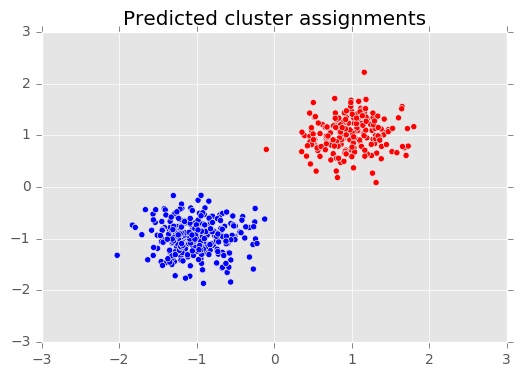

In [10]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=clusters, cmap=cm.bwr)
plt.axis([-3, 3, -3, 3])
plt.title("Predicted cluster assignments")
plt.show()

The model has correctly clustered the data.

## Remarks: The log-sum-exp trick

For a collapsed mixture model, implementing the log density can be tricky.
In general, the log density is

\begin{align*}
  \log p(\pi) +
  \Big[ \sum_{k=1}^K \log p(\mathbf{\mu}_k) + \log
  p(\mathbf{\sigma}_k) \Big] +
  \sum_{n=1}^N \log p(\mathbf{x}_n \mid \pi, \mu, \sigma),
\end{align*}

where the likelihood is

\begin{align*}
  \sum_{n=1}^N \log p(\mathbf{x}_n \mid \pi, \mu, \sigma)
  &=
  \sum_{n=1}^N \log \sum_{k=1}^K \pi_k \, \text{Normal}(\mathbf{x}_n \mid
  \mu_k, \sigma_k).
\end{align*}

To prevent numerical instability, we'd like to work on the log-scale,

\begin{align*}
  \sum_{n=1}^N \log p(\mathbf{x}_n \mid \pi, \mu, \sigma)
  &=
  \sum_{n=1}^N \log \sum_{k=1}^K \exp\Big(
  \log \pi_k + \log \text{Normal}(\mathbf{x}_n \mid \mu_k, \sigma_k)\Big).
\end{align*}

This expression involves a log sum exp operation, which is
numerically unstable as exponentiation will often lead to one value
dominating the rest. Therefore we use the log-sum-exp trick.
It is based on the identity

\begin{align*}
  \mathbf{x}_{\mathrm{max}}
  &=
  \arg\max \mathbf{x},
  \\
  \log \sum_i \exp(\mathbf{x}_i)
  &=
  \log \Big(\exp(\mathbf{x}_{\mathrm{max}}) \sum_i \exp(\mathbf{x}_i -
  \mathbf{x}_{\mathrm{max}})\Big)
  \\
  &=
  \mathbf{x}_{\mathrm{max}} + \log \sum_i \exp(\mathbf{x}_i -
  \mathbf{x}_{\mathrm{max}}).
\end{align*}

Subtracting the maximum value before taking the log-sum-exp leads to
more numerically stable output. The $\texttt{Mixture}$ random variable
implements this trick for calculating the log-density.